In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

In [4]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df = pd.read_csv('/content/URC Historical Data_Cleaned.csv', usecols=['Date', 'Price'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()
df = df.asfreq('B')

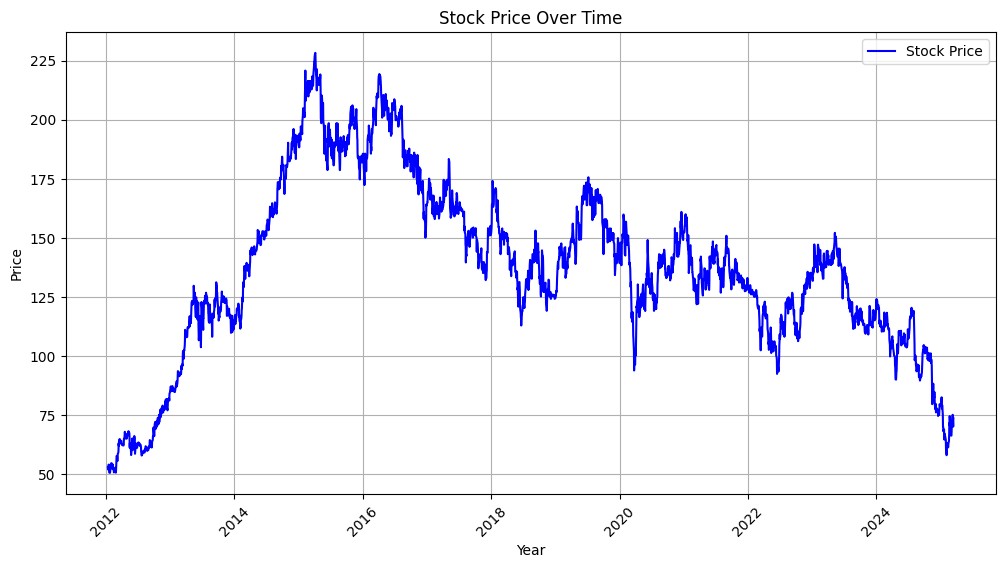

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label="Stock Price", color='blue')
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Stock Price Over Time")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.grid()
plt.show()

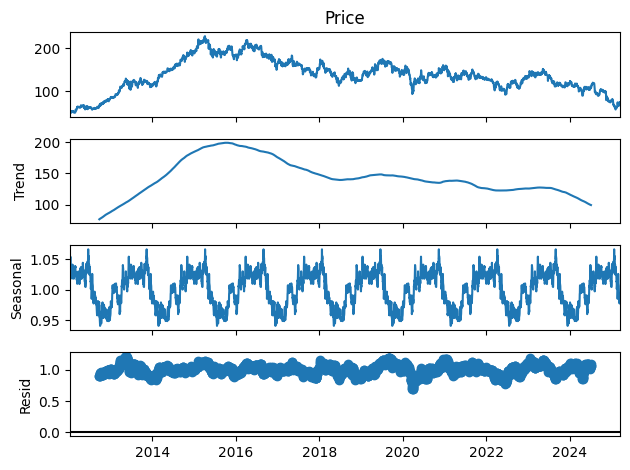

In [6]:
results = seasonal_decompose(df['Price'], model='multiplicative', period=365)
results.plot()
plt.show()

In [7]:
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
train = df.iloc[:train_size]
val = df.iloc[train_size:train_size+val_size]
test = df.iloc[train_size+val_size:]

In [8]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test)

In [9]:
scaled_train = np.array(scaled_train).reshape(-1, 1)
scaled_val = np.array(scaled_val).reshape(-1, 1)
scaled_test = np.array(scaled_test).reshape(-1, 1)

In [10]:
n_input = 90
n_features = 1
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
val_generator = TimeseriesGenerator(scaled_val, scaled_val, length=n_input, batch_size=1)

In [11]:
model = Sequential([
    LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_input, n_features)),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 90, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,301 (282.43 KB)

 Trainable params: 72,301 (282.43 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
checkpoint = ModelCheckpoint("URC_model.h5", save_best_only=True, monitor='val_loss', mode='min')

In [13]:
history = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[early_stopping, checkpoint])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0098

2658/2658 ━━━━━━━━━━━━━━━━━━━━ 259s 96ms/step - loss: 0.0098 - val_loss: 4.4281e-04
Epoch 2/30
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0017

2658/2658 ━━━━━━━━━━━━━━━━━━━━ 250s 94ms/step - loss: 0.0017 - val_loss: 3.5089e-04
Epoch 3/30
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 254s 96ms/step - loss: 0.0013 - val_loss: 6.7338e-04
Epoch 4/30
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 245s 92ms/step - loss: 0.0014 - val_loss: 4.5533e-04
Epoch 5/30
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0012

2658/2658 ━━━━━━━━━━━━━━━━━━━━ 249s 94ms/step - loss: 0.0012 - val_loss: 2.1918e-04
Epoch 6/30
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 251s 94ms/step - loss: 0.0011 - val_loss: 3.4624e-04
Epoch 7/30
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0011

2658/2658 ━━━━━━━━━━━━━━━━━━━━ 246s 92ms/step - loss: 0.0011 - val_loss: 2.1629e-04
Epoch 8/30
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 248s 93ms/step - loss: 8.7948e-04 - val_loss: 2.7340e-04
Epoch 9/30
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 8.8458e-04

2658/2658 ━━━━━━━━━━━━━━━━━━━━ 248s 93ms/step - loss: 8.8457e-04 - val_loss: 1.9597e-04
Epoch 10/30
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 244s 92ms/step - loss: 8.8120e-04 - val_loss: 1.9932e-04
Epoch 11/30
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 271s 95ms/step - loss: 8.7310e-04 - val_loss: 6.1763e-04
Epoch 12/30
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 246s 93ms/step - loss: 7.2114e-04 - val_loss: 5.3696e-04
Epoch 13/30
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 246s 92ms/step - loss: 7.9333e-04 - val_loss: 2.1270e-04
Epoch 14/30
2658/2658 ━━━━━━━━━━━━━━━━━━━━ 250s 94ms/step - loss: 8.5147e-04 - val_loss: 2.1892e-04


In [14]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
model.save("URC_Model.h5")

In [15]:
full_scaled = scaler.transform(df)
full_scaled = np.array(full_scaled).reshape(-1, 1)
first_eval_batch = full_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

future_steps = 7
future_predictions = []

for i in range(future_steps):
    current_pred = model.predict(current_batch)[0]
    future_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


In [16]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [17]:
actual_recent = df.tail(23)

In [18]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=future_steps, freq='B')

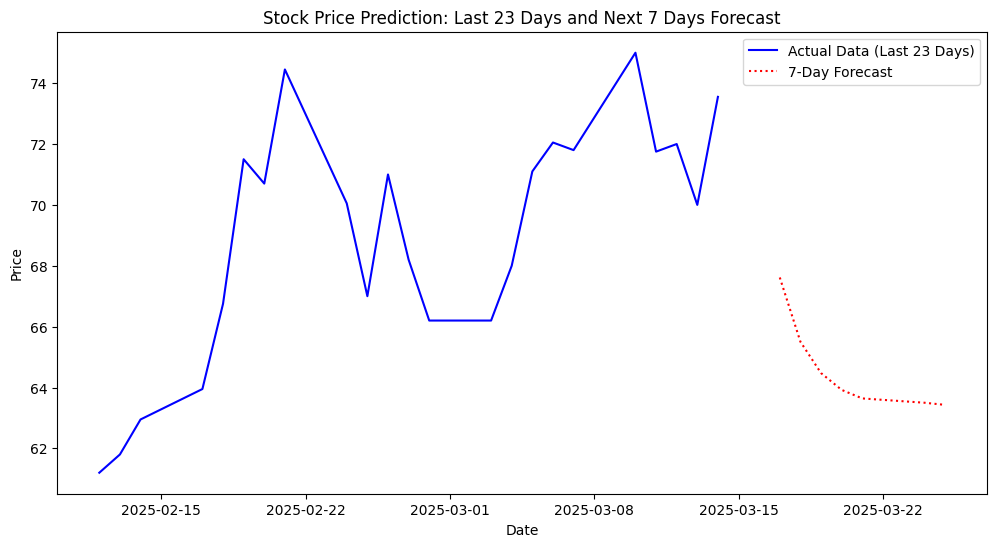

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(actual_recent.index, actual_recent['Price'], label='Actual Data (Last 23 Days)', color='blue')
plt.plot(future_dates, future_predictions, linestyle='dotted', color='red', label='7-Day Forecast')
plt.legend()
plt.title("Stock Price Prediction: Last 23 Days and Next 7 Days Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [20]:
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_predictions.flatten()
})

In [21]:
forecast_df.to_csv('URC_predictions.csv', index=False)

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print("Future predictions saved to 'future_predictions.csv'.")

Future predictions saved to 'future_predictions.csv'.
